In [3]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv

# Birth Death Reaction

$ \varnothing \stackrel{k_1}\longrightarrow M $

$ M \stackrel{k_2}\longrightarrow \varnothing $

BUT: reaction rate constants are not the rates of the chain, death rate is proportional to the number of molecules = $ k_2 * m $

# Simulation: Paths and Bootstrap

In [4]:
def sample_path(x0, params, tmax, plot=False):
    """
    Simulate sample path of birth death reaction

    x0 = initial state
    params = [k1, k2]
    tmax = time of simulation

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    if plot:
        plt.step(jump_times, path, where="post")

    return path, jump_times

In [5]:
def bootstrap(x_list, x0, params, tmax, n, N, plot=False, printing=False):
    """
    x_list = states to calculate probabilities for
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax, plot=plot)
        states.append(path[-2])
    if plot:
        plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

### Test

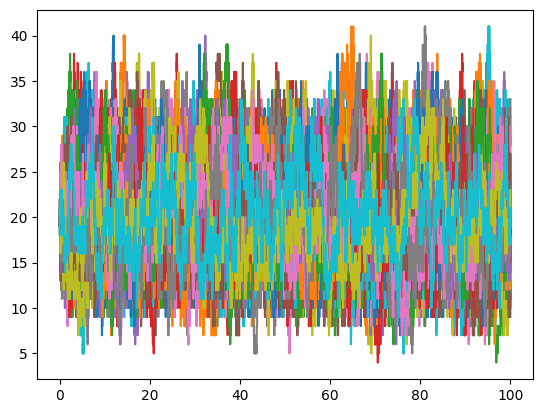

95% CI for p(19) is: (0.06, 0.18)


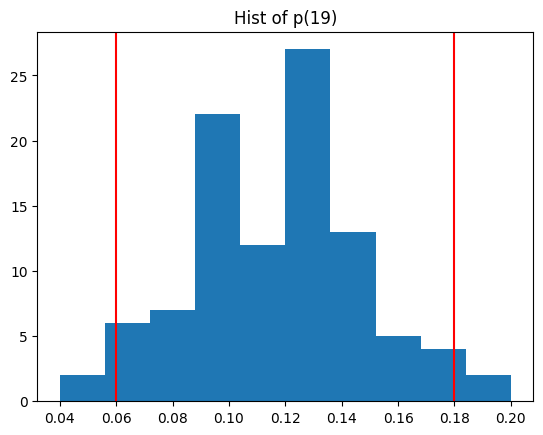

95% CI for p(20) is: (0.06475, 0.20049999999999982)


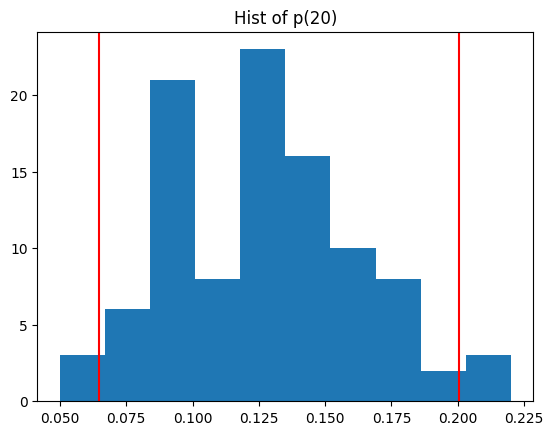

95% CI for p(21) is: (0.05, 0.14)


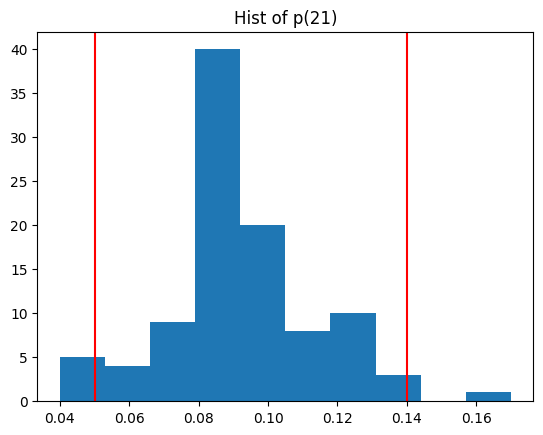

In [4]:
bootstrap([19,20,21],20,[20,1],100,100,100,plot=True,printing=True);

# Confidence intervals

## Relation to true values

Start by plotting confidence interval estimates (as intervals on a graph) against the true value p(x) they are estimating:

In [52]:
def CI_analysis_1(n, N):
    """
    Plot confidence interval estimates for a range of stationary values p(x)
    n = number of samples (from the stationary distribution)
    N = number of bootstrap samples (resamples with replacement of size n)
    """
    # fix k2
    k2 = 1
    # take selection of p(x)'s
    x_min = 0
    x_max = 5
    count = 0
    count_red = 0
    # range of k1 parameter values
    for k1 in 3 * [0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
    #for k1 in [1 for x in range(30)]:
        # true p(x) values
        true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]
        # bootstrap estimates
        estimates, intervals = bootstrap([x for x in range(x_min, x_max)],0,[k1,k2],100,n,N)
        # plot each CI
        for i in range(x_max - x_min):
            p = true_p[i]
            l = intervals[i][0]
            u = intervals[i][1]
            count += 1
            if l <= p and p <= u:
                color = "blue"
            else:
                color = "red"
                count_red += 1
            plt.plot([p, p], [l, u], color=color, alpha=0.7)
    plt.axline([0, 0], slope=1, color="green")
    plt.xlabel("True value of p(x)")
    plt.ylabel("CI for p(x)")
    plt.show()

    print(f"Proportion of CI's not containing true value: {count_red / count}")

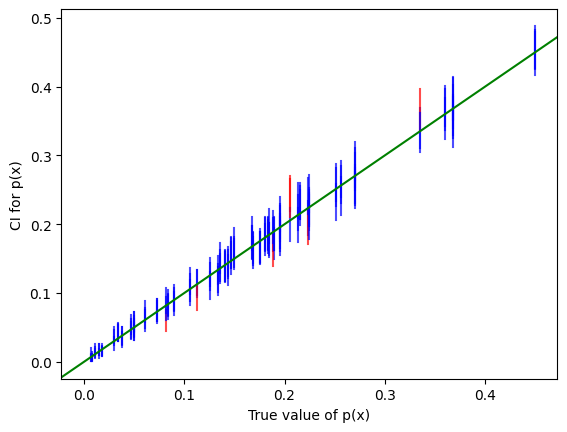

Proportion of CI's not containing true value: 0.04666666666666667


In [53]:
CI_analysis_1(1000, 1000)

### Larger sample size:

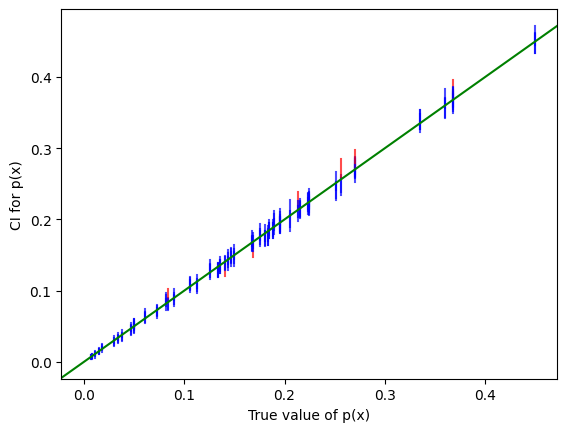

Proportion of CI's not containing true value: 0.04666666666666667


In [48]:
CI_analysis_1(5000, 5000)

### Smaller sample: increasing number of bootstrap samples

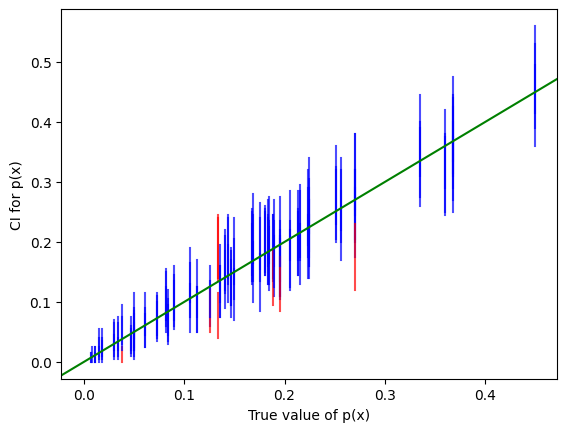

Proportion of CI's not containing true value: 0.07333333333333333


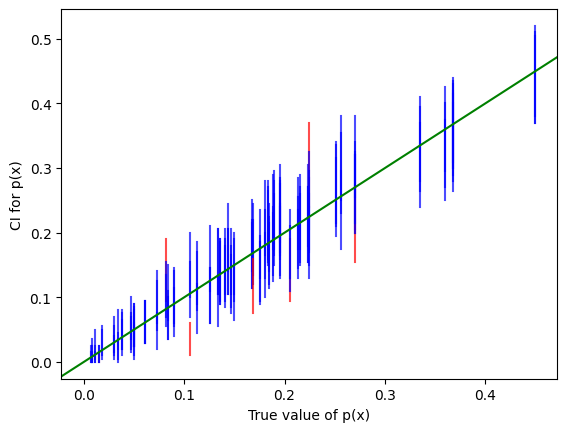

Proportion of CI's not containing true value: 0.06


In [54]:
CI_analysis_1(200, 1000)
CI_analysis_1(200, 5000)

A larger sample size visibily reduces the width of the intervals, and slightly reduces the proportion that do not contain the true value they are estimating, but this still remains at ~5% (as expected for a 95% CI).

In practice we cannot increase the size of our sample, but we see that taking more bootstrap samples slightly improves the width and accuracy of bounds on the stationary distribution, altough not significantly in the face of increased computation time, and even with 200 original samples 1000 bootstrap samples is enough to get reasonable results.

## Accuracy: containing the true value

See that the proportion of confidence interval estimates containing the true values they are estimating is ~95% (with ~5% failing to do so), which is good as taking the 2.5% and 97.5% percentiles of the bootstrap estimates we expect a 95% confidence interval.

However, if the true values to be estimated are very small probabilities this does not hold and the proportion of 'correct' CI's drops well below 95%. We would like to know more about this: what is the relationship between CI accuracy and value size

In [55]:
def CI_analysis_2(n, N):
    # fix k2
    k2 = 1
    # take selection of p(x)'s
    x_min = 0
    x_max = 10
    # range of k1 parameter values
    #for k1 in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5]:
    for k1 in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,5]:
        # true p(x) values
        true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]
        
        # compute several bootstrap estimates and record accuracy
        accuracy = [0 for x in range(x_min, x_max)]
        m = 30
        for i in range(m):
            # bootstrap estimate
            estimates, intervals = bootstrap([x for x in range(x_min, x_max)],0,[k1,k2],100,n,N)
            # accuracy for each p(x)
            for x in range(x_min, x_max):
                if intervals[x][0] <= true_p[x] and true_p[x] <= intervals[x][1]:
                    accuracy[x] += 1 / m
        # plot accuracy
        plt.scatter(true_p, accuracy, color="blue")

    # plotting code
    plt.axhline(0.95, color="red")
    plt.title("Confidence Interval Accuracy ~ True Value")
    plt.xlabel("True value of p(x)")
    plt.ylabel("Accuracy of CI")
    plt.show()

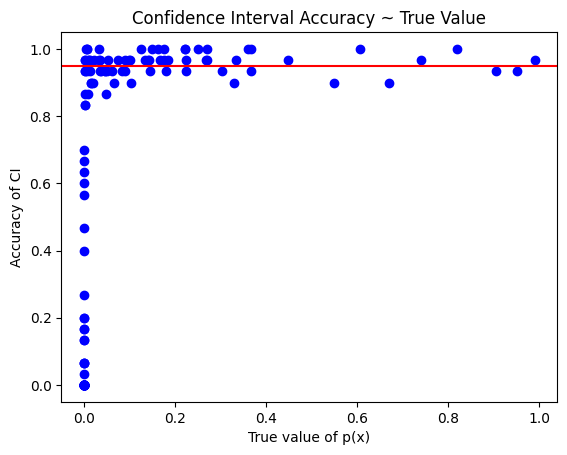

In [57]:
CI_analysis_2(1000, 1000)

Clearly see that confidence intervals for p(x) values close to 0 rarely contain the true value, but for values of p(x) that are not so small the accuracy is close to 95% or higher. 

Note: the accuracy is in general quite low because we are looking at small $k_{1}$ values (0.1 etc) and many terms of the distribution (10) which have very small values (some reaching $10^{-17}$) and so are likely to have no observations, giving an obviously innaccurate CI of [0, 0]. In practical situations we would compute CI's only for states x that have been observed (multiple times) in the sample giving much more accurate confidence intervals, matching the 95% accuracy seen earlier.

In [47]:
k1, k2 = 0.1, 1
k = 10
(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k)

2.493489357462412e-17

In conclusion, confidence intervals for p(x) values that are very close to 0 should not be trusted, as they rarely contain the true value (<< 95% of the time) and so are not suitable to use as bounds. For values of p(x) that are not very close to 0, such as in practical cases where there are at least several observations of the state x in the sample, the confidence intervals should contain the true value 95% of the time, and so are appropriate to use.

## Width: measure of confidence

The width of a confidence interval is a measure of confidence: assuming that 95% of the time the true value lies within the interval (we will assume this from now on), a smaller interval means we are more certain about the location of the true value. Since we are using the CI's as bounds on variables in a linear program there is also a direct link between the width of the CI and the width of the solution bounds, so it is important to understand how the width varies.

We compute confidence interval estimates for a range of values of p(x), plotting their widths against the true value p(x):

In [66]:
def width(intervals):
    return [interval[1] - interval[0] for interval in intervals]

In [70]:
def CI_analysis_3(t):
    # estimate 
    x_max = 10
    x_min = 0
    k2 = 1
    true_p = np.array([])
    relative_var = np.array([])
    for k1 in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5]:
        # true stat dist
        dist = np.array([(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)])
        true_p = np.append(true_p, dist)
        # find CI
        estimates, intervals = bootstrap([x for x in range(x_min, x_max)],0,[k1,k2],100,1000,1000)
        # compute widths of intervals, find relative error
        widths = np.array(width(intervals))
        if t == "abs":
            # absolute error: no change
            scaled = widths
            title = "Width of CI for p(x)"
        elif t == "rel":
            # relative error: divide width by true value
            scaled = widths / dist
            title = "Width of CI for p(x) / p(x)"
        elif t == "rel2":
            # relative error dividing width by sqrt(true value)
            scaled = widths / np.sqrt(dist)
            title = "Width of CI for p(x) / sqrt(p(x))"
        relative_var = np.append(relative_var, scaled)
    plt.scatter(true_p,relative_var)
    plt.xlabel("True value of p(x)")
    plt.ylabel(title)
    plt.show()

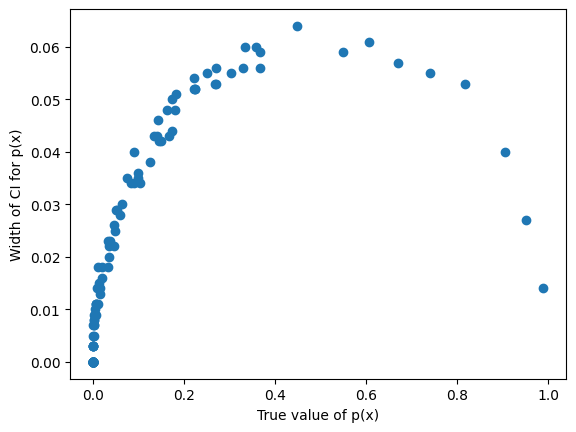

In [68]:
CI_analysis_3("abs")

We see that:

$$ \text{CI width } \propto p(x)(1 - p(x)) $$

However, the width of the CI is a measure of absolute error: p = 0.5 means we might expect 450 - 550 observations in a sample of 1000 giving an absolute error of ~0.05, for p = 0.001 even an extreme variation of 0 - 10 observations in a sample of 1000 only gives an absolute error of ~0.01 (this is just for a single point estimate, but the same idea follows for our interval estimates).

To get a measure of relative error (abolsute error relative to the size of the quantity being estimated) we can divide the width by the true value of p(x) (or $\sqrt(p(x))$):

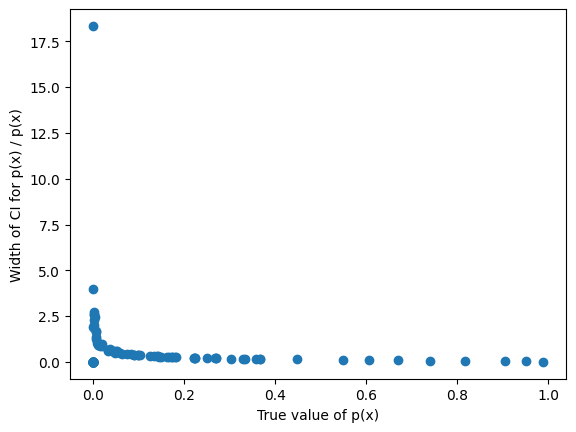

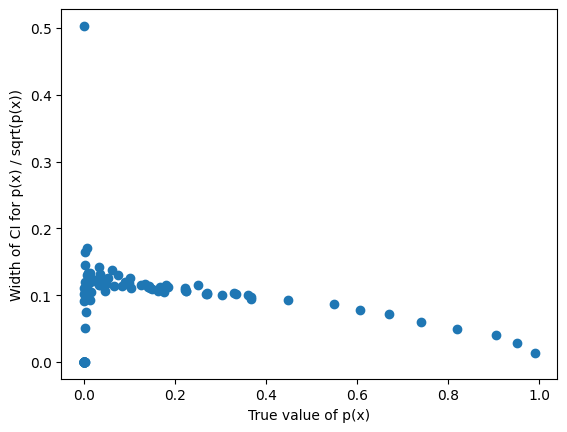

In [72]:
CI_analysis_3("rel")
CI_analysis_3("rel2")

We see that:

$$ \frac{\text{CI Width}}{p(x)} \propto \frac{1}{p(x)} $$

$$ \frac{\text{CI Width}}{\sqrt{p(x)}} \propto 1 - p(x) $$

Showing that the error decreases as p(x) increases from 0 (rapidly for case 1, more slowly for case 2) since we have sufficient observations of x in the sample to give a good estimate (lower sampling error), but that as p(x) increases towards 1 there is not a significant improvement (although the width does reduce towards 0) as we already have enough information for a good estimate.

The extreme case where p(x) is close enough to 0 that there are no observations of x in the sample can be seen: the confidence interval estimate is [0, 0] with a width of 0 (we have no estimate of uncertainty as there is no information).

# Practical concerns

In practice we do not have access to the true stationary distribution when choosing the states to use: the only information available is the sample of n observations from the stationary distribution, from which we can compute confidence interval estimates of stationary values p(x) for each x in the sample. However, including confidence intervals that are 'wrong' can lead to infeasbile or innaccurate results.

A method that seems to work well in practice is to set a 'threshold' on the number of observations of a state x in the sample needed to 'trust' the estimated confidence interval for its stationary value p(x). A value of ~3 for a sample of ~200 has been used, with confidence intervals for states below this threshold replaced by un-informative [0, 1] bounds.

We saw above that for p(x) values very close to 0 (that would give a small number of observations of x in a sample) the accuracy of confidence interval estimates was very low, the widths can vary significantly, and in the extreme case of no observations become [0, 0] (with no way to tell if this is accurate). From this it seems reasonable to consider thresholding, as # observations of x > threshold suggests that p(x) is large enough to avoid accuracy problems, especialy when working with real data where the sampling error is likely to be large.

However, we test this method on simulated data to be sure:
- simulate a sample
- compute confidence intervals for all states, marking those that fall below the threshold number of samples (and so would not be used)
- compare the properties: accuracy and width, of confidence intervals of each group (are marked states truly un-trustworthy)
- finally consider different thresholds to see if there is an 'optimal' range (is ~3 really the best?)

In [169]:
def CI_analysis_4(x0, params, tmax, n, N, threshold):
    """
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    threshold = minimum frequency
    """

    k1, k2 = params

    # simulate sample of size n from stationary distribution
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax)
        states.append(path[-2])
    
    # take the largest state in the sample (+ 1)
    x_max = np.max(np.array(states)) + 1
    x_min = np.min(np.array(states))

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in range(x_min, x_max)]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(range(x_min, x_max)):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]

    # true stationary distribution
    true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]
    
    # plot:
    # histogram of stationary sample
    plt.hist(sample, bins=np.arange(x_min, x_max) - 0.5, density=True, label="Stationary sample");
    # threshold line
    plt.axhline(threshold / n, 0, 1, color="orange", label=f"Frequency threshold: {100 * threshold / n} %")
    # plot true stationary distribution
    plt.plot([x for x in range(x_min, x_max)], true_p, color="green", label="Stationary distribution")
    # plot confidence intervals: coloured by accuracy
    for i, interval in enumerate(intervals):
        if interval[0] <= true_p[i] and true_p[i] <= interval[1]:
            color = "blue"
        else:
            color = "red"
        x = range(x_min, x_max)[i]
        plt.plot([x, x], [interval[0], interval[1]], color=color)
    plt.title("Frequency thresholds: accuracy and width of confidence intervals")
    plt.legend()
    plt.show()

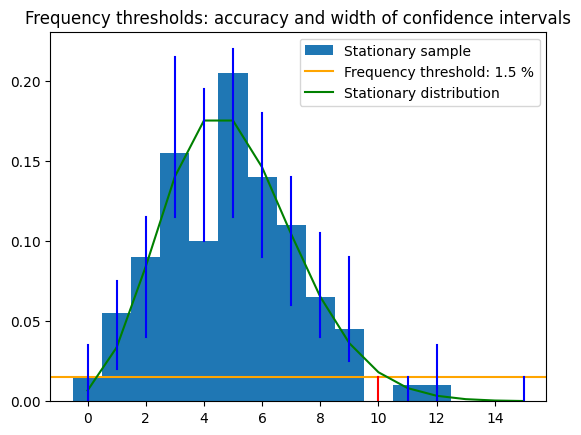

In [198]:
CI_analysis_4(1, [5, 1], 100, 200, 1000, 3)

A plot showing a histogram of the stationary sample (blue), the true stationary distribution (green), the confidence intervals for each state (vertical lines: blue if containing the true value being estimated, red if not) and a threshold frequency.

In [206]:
def CI_analysis_5(k1_list, tmax, n, N):

    # store CI data
    data = []

    # fix k2
    k2 = 1
    # range of k1 parameter values
    for k1 in k1_list:

        # setup
        x0 = 1
        params = [k1, k2]

        # simulate sample of size n from stationary distribution
        states = []
        for i in range(n):
            path, jumps = sample_path(x0, params, tmax)
            states.append(path[-2])
        
        # take the largest and smallest states in the sample (+ 1)
        x_max = np.max(np.array(states)) + 1
        x_min = np.min(np.array(states))

        # simulate N bootstrap samples: estimates p(x) for each, and for each x
        estimates = [[] for x in range(x_min, x_max)]
        for i in range(N):
            sample = random.choices(states,k = n)
            for i, x in enumerate(range(x_min, x_max)):
                estimates[i].append(sample.count(x) / n)

        # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
        intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]

        # true stationary distribution
        true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_min, x_max)]

        # record: frequency of samples CI is based on, accuracy (T/F), width
        for i, interval in enumerate(intervals):
            # interval estimate of p(x) for state x
            x = range(x_min, x_max)[i]
            # number of occurances in the sample
            freq = sample.count(x)
            # accuracy
            if interval[0] <= true_p[i] and true_p[i] <= interval[1]:
                acc = 1
            else:
                acc = 0
            # width
            width = interval[1] - interval[0]

            # store
            data.append([freq, acc, width])

    # plot % accuracy of CI's against frequency of samples they are based on
    freqs = {x[0]: [] for x in data}
    for x in data:
        freqs[x[0]].append(x[1])
    for x, y in freqs.items():
        freqs[x] = sum(y) / len(y)
    plt.scatter(freqs.keys(), freqs.values())
    plt.xlabel("Frequency of x in stationary sample")
    plt.ylabel("Confidence intervals for p(x) containing true value (%)")
    plt.title("Accuracy of confidence intervals ~ frequency of data")
    plt.show()

    return data

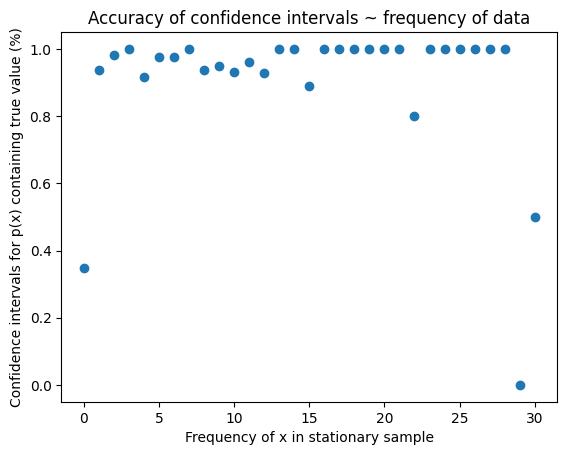

In [208]:
CI_analysis_5(10 * [20, 50], 100, 200, 1000);

There is not a clear relationship between the frequency of a state x in the sample, and the accuracy of confidence intervals estimating p(x) (i.e. not a clear relationship such as an elbow) especially since in the vast majority of cases the CI's should be accuracte 95% of the time.

However, for frequencies of states at or close to 0, the accuracy of confidence intervals is lower than 95%, even significantly so. When working with real data this effect is likely to be exacebated by greater sampling error, missing values, etc which all contribute to reduced accuracy. 

In conclusion, using thresholds on the frequency of states in the sample can avoid low accuracy confidence intervals, and we have observed good results in practice (see bursty_data_analysis for practical data exploration).

# Create LP

In [5]:
def birth_death_LP(indices, pl, pu, printing=False):
    """
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    pl = array of lower bounds on p (enough for equations used)
    pu = array of upper bounds on p ( == )

    returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Construct the problem.
    k1 = cv.Variable(1)
    k2 = 1
    z1 = cv.Variable(N + 1)
    z2 = cv.Variable(N + 1)
    objective_max = cv.Maximize(k1)
    objective_min = cv.Minimize(k1)
    constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                z1 >= k1 * pl,
                z1 <= k1 * pu,
                z2 >= k2 * pl,
                z2 <= k2 * pu]
    prob_max = cv.Problem(objective_max, constraints)
    prob_min = cv.Problem(objective_min, constraints)   

    # Print result.
    result_max = prob_max.solve()
    if printing:
        print("\nThe upper bound is", prob_max.value)
        print("A solution k1 is")
        print(k1.value)
    max_bound = k1.value
    result_min = prob_min.solve()
    if printing:
        print("\nThe lower bound is", prob_min.value)
        print("A solution k1 is")
        print(k1.value)
    min_bound = k1.value
    
    return prob_min.value, prob_max.value

## Test

In [213]:
# create confidence intervals
k1 = 5
x_max = 12
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,2000,2000)

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# use as bounds for BD LP
lb, ub = birth_death_LP([0,1,2,8,9,10],pl,pu,printing=True)


The upper bound is 5.883314267168958
A solution k1 is
[5.88331427]

The lower bound is 3.5615763537977756
A solution k1 is
[3.56157635]


# Width of solution interval ~ equations used

When solving the linear program we have the contraint Qp = 0 (for the p(x)'s where we have bounds: $p_{l}(x) \le p(x) \le p_{u}(x)$ ), a system of linear equations. We could use all possible equations but as seen above the CI bounds can be unrealiable, and large LP's can become computationally problematic, so we would like to know which equations are the most 'important': give the narrowest solution bounds.

Indexing the rows of Q / equations of Qp = 0 from 0, equation n involves p(n - 1), p(n), p(n + 1), except only p(0), p(1) for n = 0. (To use equation n we must then have bounds on these values).

# Single equations

Start by simulating bounds for a range of states [0, ..., x] and solving an LP using only a single equation each time, plotting the solution interval, and its width, against the equation used:

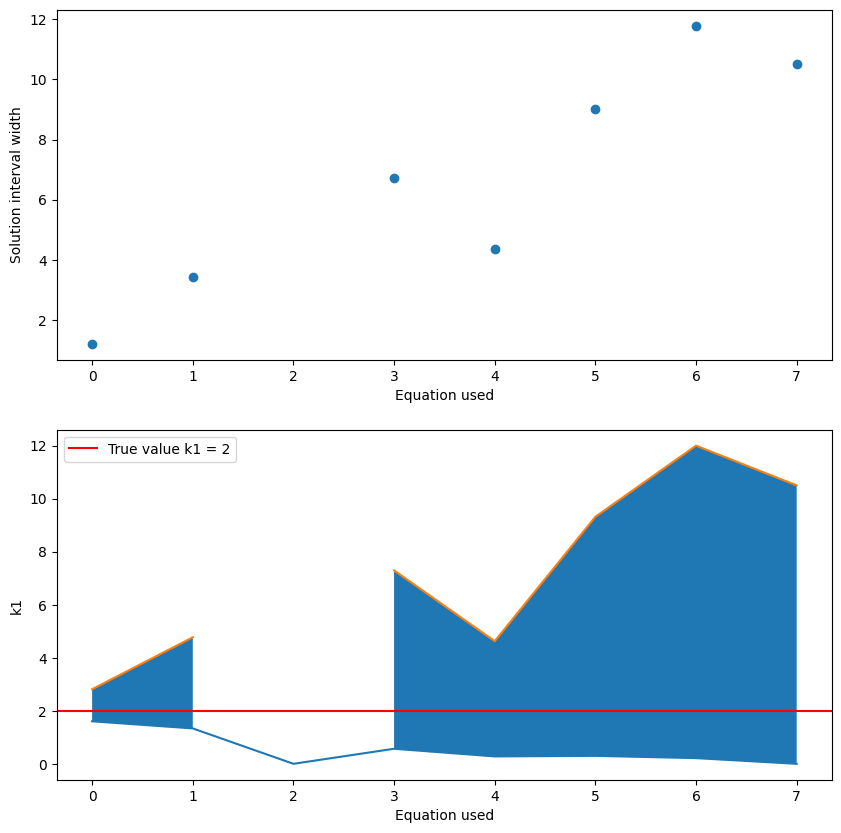

In [232]:
# choose parameter
k1 = 2
solution_width = []
upper_bounds = []
lower_bounds = []
equation = []
# compute CI bounds for a range of p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],0,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# for each n: solve LP using eqn. n alone
for n in range(8):
    lb, ub = birth_death_LP([n],pl,pu)
    try:
        solution_width.append(ub - lb)
        lower_bounds.append(lb)
        upper_bounds.append(ub)
        equation.append(n)
    except TypeError:
        print(f"Type error for equation {n}, ub {ub}, lb {lb}")
# plot: scatter CI width, plot lines of upper and lower bounds against equation used
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))
ax[0].scatter(equation, solution_width)
ax[0].set(xlabel="Equation used", ylabel="Solution interval width")
ax[1].plot(equation, lower_bounds)
ax[1].plot(equation, upper_bounds)
ax[1].set(xlabel="Equation used", ylabel="k1")
ax[1].fill_between(equation, lower_bounds, upper_bounds)
ax[1].axhline(k1, color="red", label=f"True value k1 = {k1}")
plt.legend()
plt.show()

### Why does the equation n = k1 give no upper bound?

The stationary distribution of the birth-death reaction is $ \text{Poisson} \left(\frac{k_1}{k_2}\right) $ which has a mode at $\frac{k_1}{k_2}$. However, when $\frac{k_1}{k_2}$ is an integer the distribution is bi-modal:

$\frac{k1}{k2} \in \mathbb{N} \implies P(X = \frac{k1}{k2}) = P(X = \frac{k1}{k2} + 1) \text{ for } X \sim Poi(\frac{k1}{k2})$ 

So states $ \frac{k1}{k2} $ and $ \frac{k1}{k2} +1 $ have the same (largest) stationary distribtuion values.

This causes all $k_{1}$ terms to cancel in equation $\frac{k_1}{k_2}$, giving no bounds on its value (only a lower bound of 0 as manually enforced by a constraint).

## Best single equation

To find the best single equation to use, for given parameters:
- Generate a sample and bounds, solve using each equation alone
- record the equation(s) giving the smallest solution interval, that contains the true value of $k_1$ (count all minima)
- repeat for a large number of samples
- produce the distribution of best equations

In [238]:
def equation_distribution(params, M, N):
    """
    params = [k1, k2]
    M = number of samples
    N = number of equations to use
    """
    # fixed parameters
    k1 = params[0]
    k2 = params[1]
    # store best equations
    best_equation = []
    for i in range(M):
        # store values
        solution_width = []
        upper_bounds = []
        lower_bounds = []
        equation = []
        # compute CI bounds on p(x)'s
        estimates, intervals = bootstrap([x for x in range(N + 1)],0,[k1,k2],100,1000,1000)
        pl = [intv[0] for intv in intervals]
        pu = [intv[1] for intv in intervals]
        # using equation n: solve LP
        for n in range(N):
            lb, ub = birth_death_LP([n],pl,pu)
            try:
                solution_width.append(ub - lb)
                upper_bounds.append(ub)
                lower_bounds.append(lb)
                equation.append(n)
            except TypeError:
                print(f"Type error for equation {n}, ub {ub}, lb {lb}")
        # find equation of minimum solution width
        # (NOTE: equation should be equal to index, but making sure)
        best_equation.append(equation[np.argmin(solution_width)])
    # plot distribution of best equation: proportion of equation #'s among best
    eqn_dist = [best_equation.count(x) / M for x in range(N)]
    plt.plot(eqn_dist)

    return eqn_dist

In [243]:
def equation_distribution_multiple(params, M, N):
    """
    params = [k1, k2]
    M = number of samples
    N = number of equations to use
    """
    # fixed parameters
    k1 = params[0]
    k2 = params[1]
    # store best equations
    best_equation = []
    for i in range(M):
        # store values
        solution_width = []
        equations = []
        # compute CI bounds on p(x)'s
        estimates, intervals = bootstrap([x for x in range(N + 1)],0,[k1,k2],100,1000,1000)
        pl = [intv[0] for intv in intervals]
        pu = [intv[1] for intv in intervals]
        # using equation n: solve LP
        for n in range(N):
            lb, ub = birth_death_LP([n],pl,pu)
            try:
                # if solution interval contains true value
                if lb <= k1 and k1 <= ub:
                    solution_width.append(ub - lb)
                    equations.append(n)
            except TypeError:
                print(f"Type error for equation {n}, ub {ub}, lb {lb}")
        # find equations (potentially multiple) that give min. solution width
        min_width = np.min(solution_width)
        for i, width in enumerate(solution_width):
            if width == min_width:
                best_equation.append(equations[i])
    # plot distribution of best equation: proportion of equation #'s among best
    eqn_dist = [best_equation.count(x) / len(best_equation) for x in range(N)]
    plt.plot(eqn_dist)
    plt.xlabel("Equation used")
    plt.title("Distribution of equations giving smallest solution interval")

    return eqn_dist

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


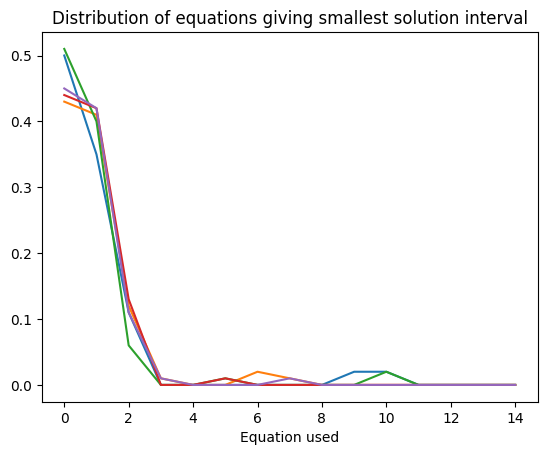

In [251]:
dists = []
for i in range(5):
    dist = equation_distribution_multiple([4,1],100,15)
    dists.append(dist)

Finding the distribution for $k_1$ = 4 (repeating 5 times for consistency), we see that equation n = 4 is never the best choice due to the bi-modal issues discussed. Equations 5 - 10 are rarely the best choice, but sometimes do provide the best bounds: bootstrap intervals contain the true value 95% of the time and their widths vary, so it is expected that over many samples these equations may give the best bounds.

However, equations 0 and 1 clearly dominate the distribution (with some weight on 2), possible reasons for this are:
- uniqueness of state 0: there is only 1 possible jump of the chain compared to all other states, perhaps leading to a higher frequency and more consistent/accurate bootstraps. p(0) only occurs in equations n = 0 and 1
- equation 0 has only 2 variables: all others have 3, so the resulting bounds may be tighter

But for stationary distributions with a mode far away from 0, giving low p(0) values and potentially poor CI bounds, will this trend still hold? 

Plot the distribution of best equations for a range of parameter values $k_1$ = 0.1, 0.25, ..., 12 (the stationary mode is indicated by a red line, where we expect a value of 0):

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


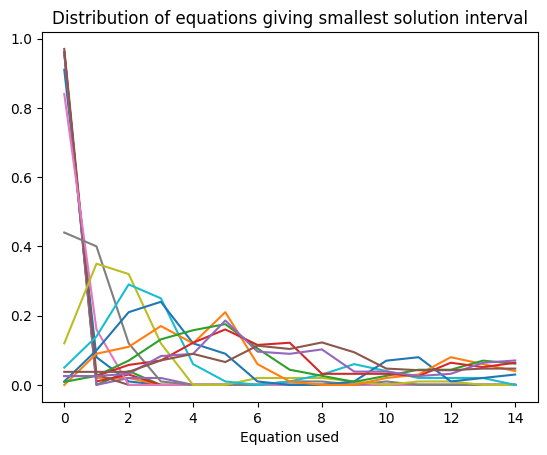

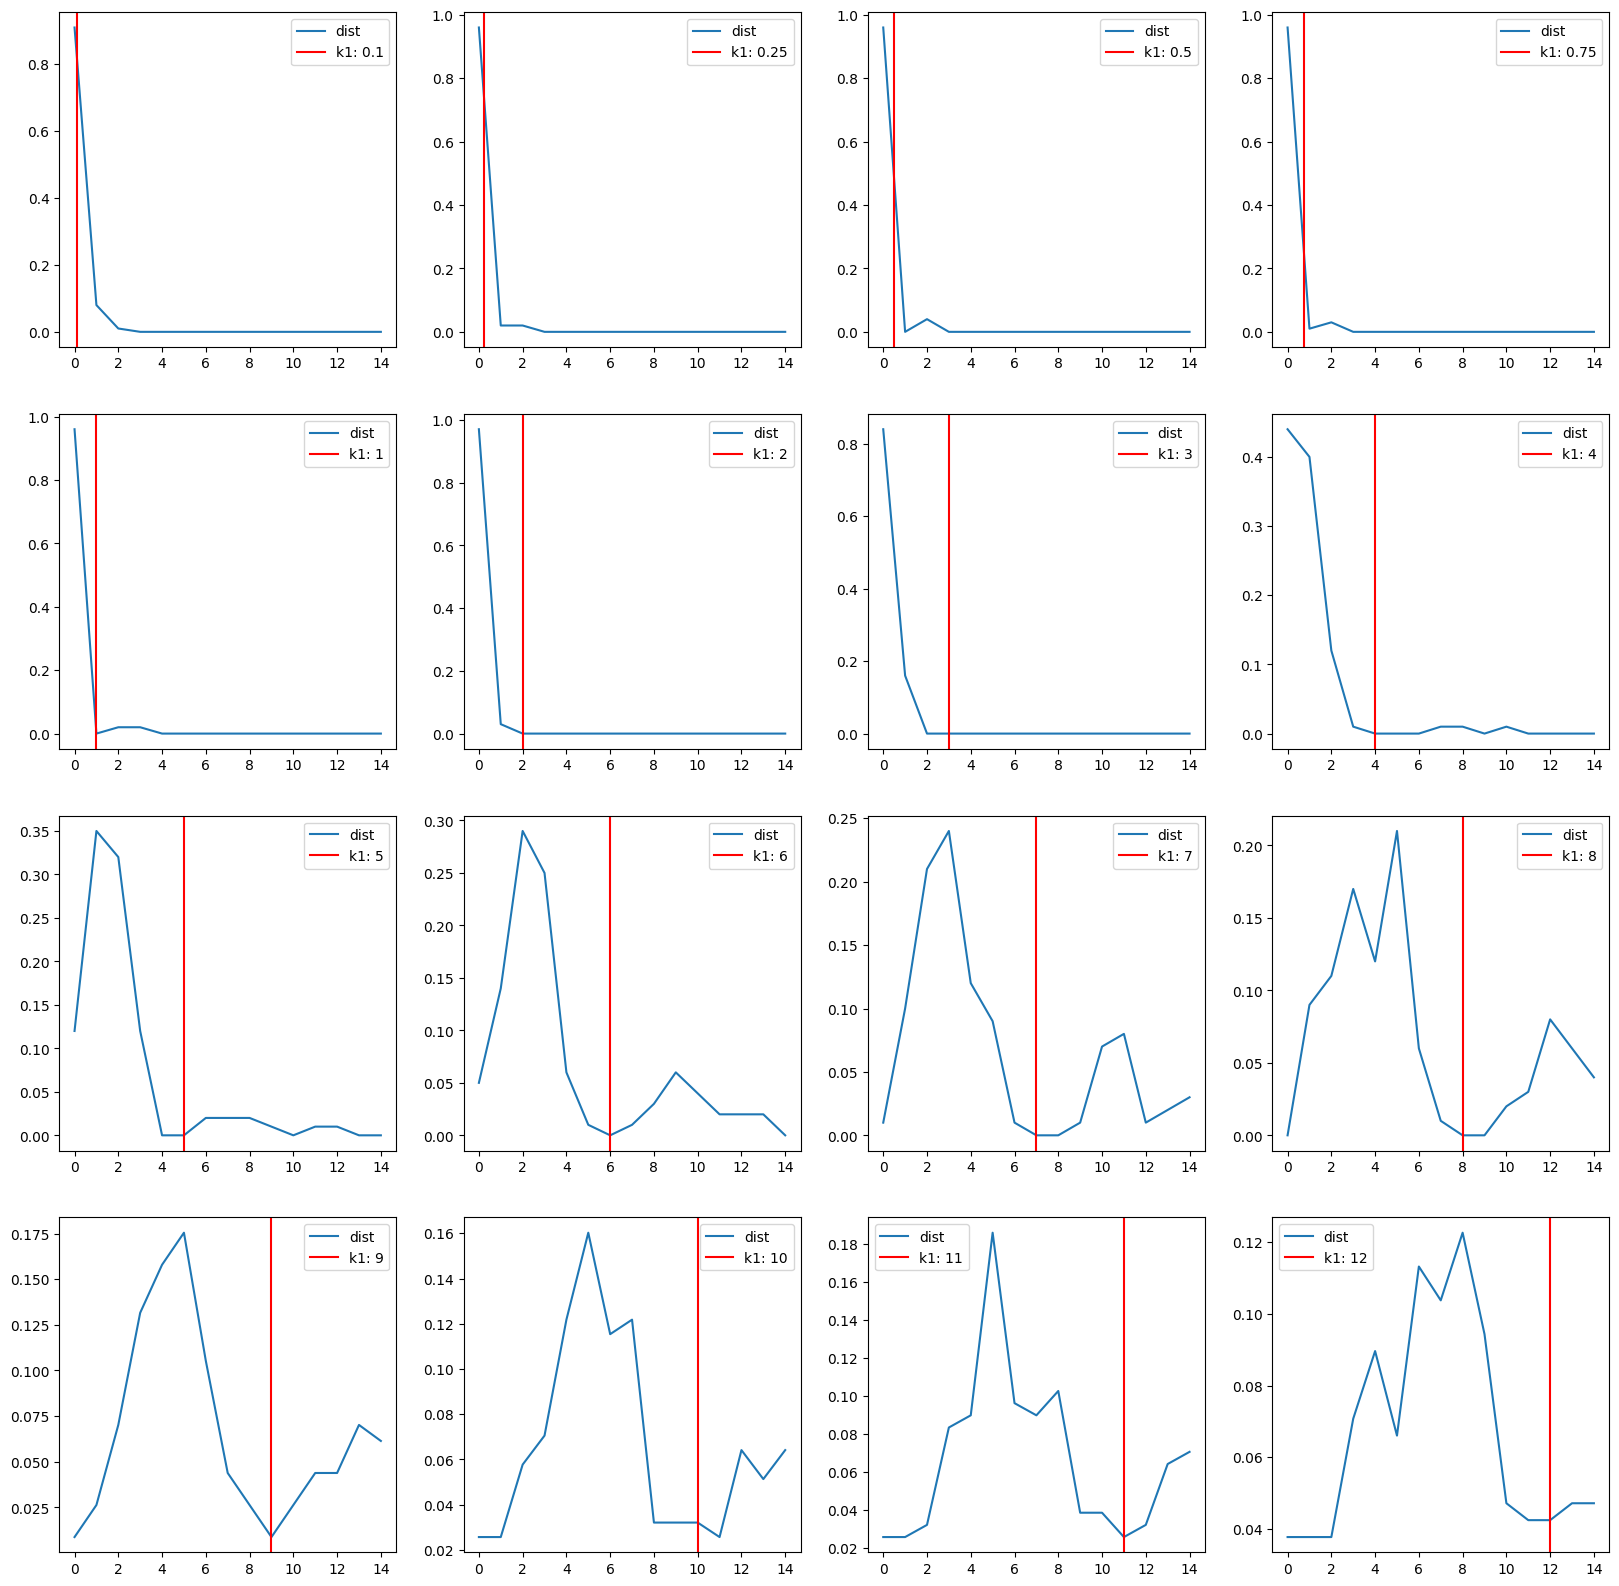

In [257]:
distributions = []
k1_list = [0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for k1 in k1_list:
    dist = equation_distribution_multiple([k1,1],100,15)
    distributions.append(dist)

nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,20))
for i in range(nrows):
    for j in range(ncols):
        idx = i * nrows + j
        k1 = k1_list[idx]
        ax[i,j].plot(distributions[idx])
        ax[i,j].axvline(k1, color='red')
        ax[i,j].legend(['dist',f'k1: {k1}'])
plt.show()

See that for small values, $k_1 \le 4$, 0 dominates the distribution, but as $k_1$ increases the peak starts to shift away from 0 to equations 1, 2, ..., likely due to p(0) becoming smaller and so its CI becoming wider/less consistent. We also see the emergence of a second peak on the other side of the modal equation: as its mode moves away from 0 the poisson stationary distribution becomes more symmetric (no longer 'cut-off' by 0) and so we expect states above the mode to do just as well as those below (though there may still be some bias towards smaller states).

For integer values of $k_1$ we see the equation n = $k_1$ is almost always 0 (sampling error means some may by chance give the best solution), so we look at distributions of best equations for parameter values that do not give bi-modal distributions:

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


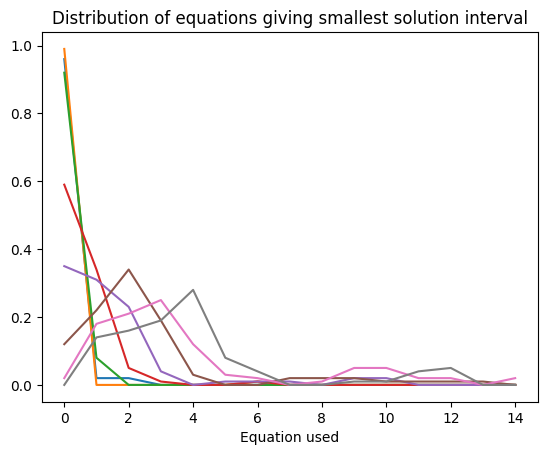

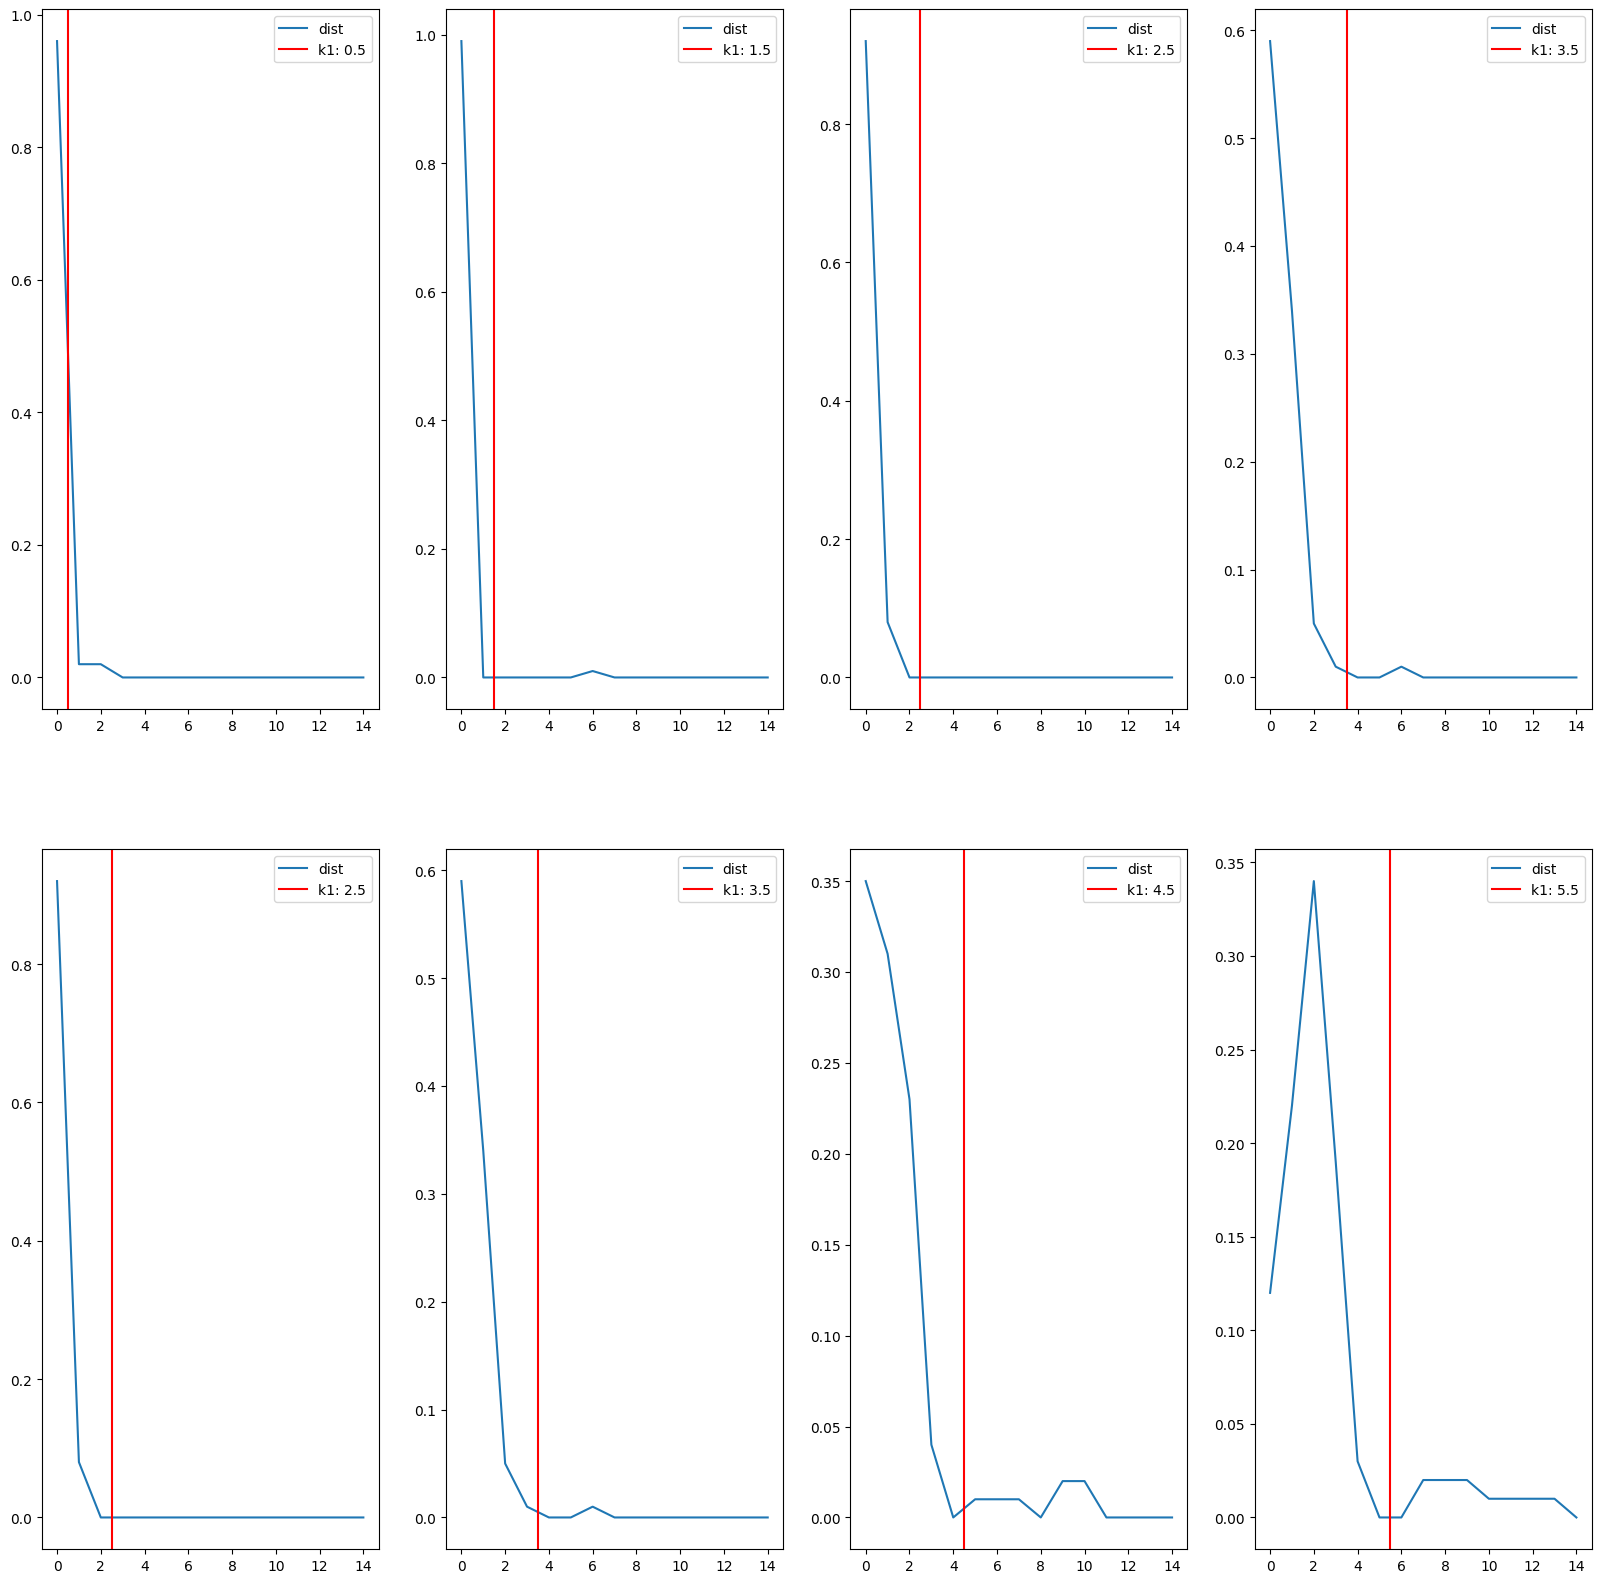

In [258]:
distributions_unimodal = []
k1_list = [x + 0.5 for x in range(8)]
for k1 in k1_list:
    dist = equation_distribution_multiple([k1,1],100,15)
    distributions_unimodal.append(dist)

nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,20))
for i in range(nrows):
    for j in range(ncols):
        idx = i * nrows + j
        k1 = k1_list[idx]
        ax[i,j].plot(distributions_unimodal[idx])
        ax[i,j].axvline(k1, color='red')
        ax[i,j].legend(['dist',f'k1: {k1}'])
plt.show()

However, we the mode state and those nearby do not see any real improvement in performance. Even though the true stationary distribution is not bi-modal, the values near the mode are still similar enough that wide CI's (such as those for high valued p(x)'s seen at the mode) overlap, leading to no/high upper solution bounds.

Finally we look at a large value of $k_1$:

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


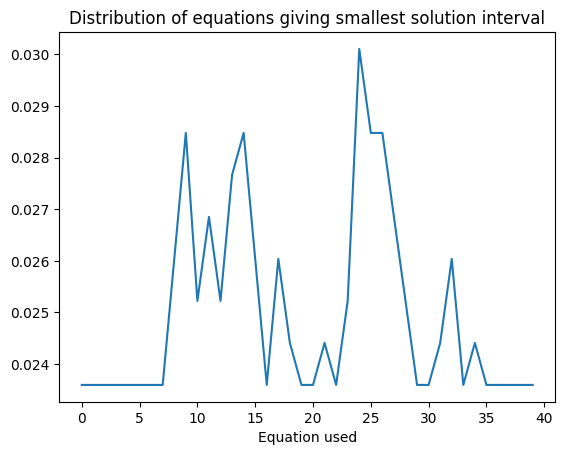

In [259]:
dist_large = equation_distribution_multiple([20,1],100,40)

- 0 loses relevance when the stationary distribution is centered far away (mode 20) and p(0) becomes too small for reliable bounds to be estimated
- the modal state and those nearby are less useful than others: close values means overlapping CI's, and the structure of the equations means no bounds are produced
- there are 2 peaks either side of the mode, roughly symmetric (slight bias to larger peak, but on a small scale)

In conclusion, the behaviour of bootstrap confidence intervals and the structure of the equations are the main factors in deciding the best equations to use. Different models will see different behaviour, but in general equations with fewer terms, those with 'special' states (0 here) and those with good confidence interval behaviour (width, accuracy) will perform well, as long as parameter terms do not cancel.

# Multiple equations

In practice we will use multiple equations. We could use as many as possible (avoiding those with innacurate bounds), but this is expensive computationally, so we want to know how many is 'enough':

- generate sample: compute bounds
- solve LP: using 1st equation, 1st and 2nd eqns, ...
- plot width of solution interval against total # equations used
- repeat for several samples to see trend

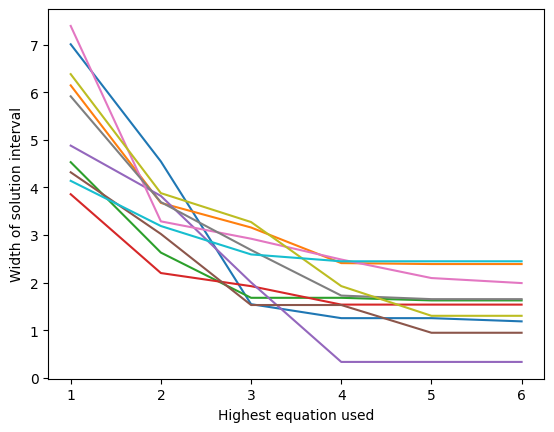

In [266]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(1, 7):
        lb, ub = birth_death_LP([x for x in range(n + 1)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(n)
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Highest equation used")
plt.ylabel("Width of solution interval")
plt.show()

(NOTE: using just equation 0 not shown, gives large width value and scale obscures detail)

See that adding the first few equations significantly improves the solution, but that subsequent additions give little to no improvements and eventually stagnate/converge. However, if too many equations are added we reach states with innaccurate confidence intervals that give conflicting constraints and an infeasible LP, meaning no solution.

Plot a single example of how the solution improves by adding equations:

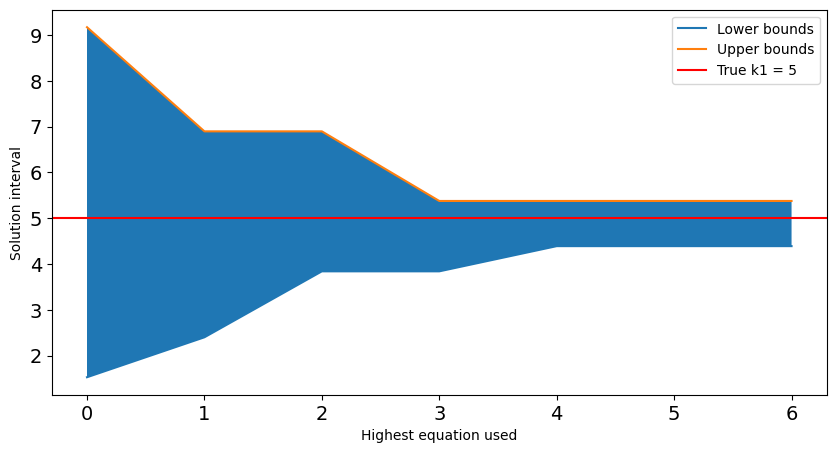

In [286]:
k1 = 5
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(0,7):
    try:
        lb, ub = birth_death_LP([x for x in range(n + 1)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Solution interval")
ax.plot(equation,lbs,label="Lower bounds")
ax.plot(equation,ubs,label="Upper bounds")
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red", label=f"True k1 = {k1}")
plt.legend()

Add equations in reverse order: start with equations n, then equations n and n - 1, ...:

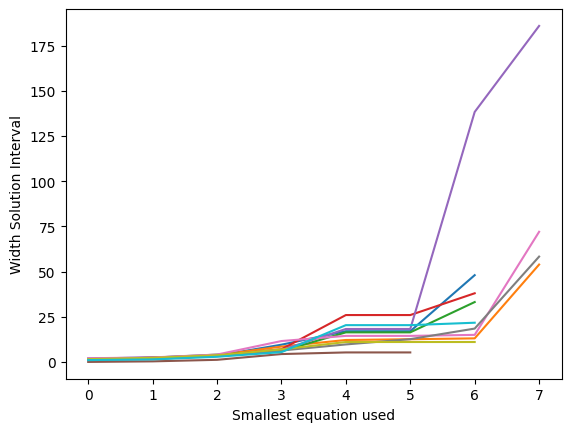

In [283]:
k1 = 5
max_eqn = 7
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(max_eqn, -1, -1):
        lb, ub = birth_death_LP([x for x in range(n, max_eqn + 1)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(n)
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Smallest equation used")
plt.ylabel("Width Solution Interval")
plt.show()

See the same behaviour: initial additions give big improvements, latter additions give small to no improvments, even equations 0, 1, 2 that dominate the single best equations for $k_1$ = 5

Plot a single example to illustrate:

c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


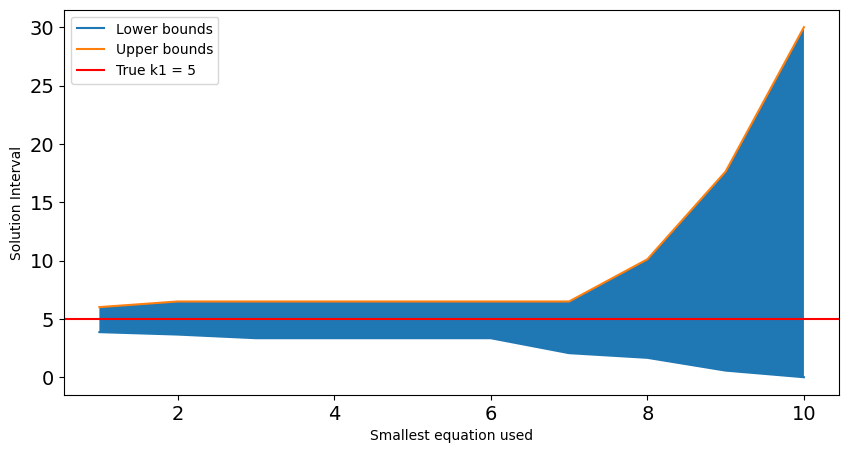

In [288]:
k1 = 5
max_eqn = 10
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(max_eqn,0,-1):
    try:
        lb, ub = birth_death_LP([x for x in range(n,max_eqn + 1)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=14)
plt.xlabel("Smallest equation used")
plt.ylabel("Solution Interval")
ax.plot(equation,lbs,label="Lower bounds")
ax.plot(equation,ubs,label="Upper bounds")
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red",label=f"True k1 = {k1}")
plt.legend()

# Additional constraint

The stationary distribution p is, of course, a distribution and so we have $0\le p(x)\le 1$ but also $ \sum_{x} p(x) = 1 $, which when truncating to a subset of the state space T gives: $ \sum_{x \in T} p(x) \le 1 $

So far we have ensured $ p(x) \in [0,1]$ (equivalently $ z_{r} \in [0, k_{r}]$) by using bootstrap confidence intervals for each p(x), which are guaranteed to be stricter than [0,1]. However, we have not explicity constrained the sum of p(x)'s, so now add and test for improvements:

In [1]:
def birth_death_LP_add(indices, pl, pu, printing=False):
    """
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    pl = array of lower bounds on p (enough for equations used)
    pu = array of upper bounds on p ( == )

    returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Construct the problem.
    k1 = cv.Variable(1)
    k2 = 1
    z1 = cv.Variable(N + 1)
    z2 = cv.Variable(N + 1)
    objective_max = cv.Maximize(k1)
    objective_min = cv.Minimize(k1)
    constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                z1 >= k1 * pl,
                z1 <= k1 * pu,
                z2 >= k2 * pl,
                z2 <= k2 * pu,
                sum([z1[x] for x in range(N + 1)]) <= k1,
                sum([z2[x] for x in range(N + 1)]) <= k2]
    prob_max = cv.Problem(objective_max, constraints)
    prob_min = cv.Problem(objective_min, constraints)   

    # Print result.
    result_max = prob_max.solve()
    if printing:
        print("\nThe upper bound is", prob_max.value)
        print("A solution k1 is")
        print(k1.value)
    max_bound = k1.value
    result_min = prob_min.solve()
    if printing:
        print("\nThe lower bound is", prob_min.value)
        print("A solution k1 is")
        print(k1.value)
    min_bound = k1.value
    
    return prob_min.value, prob_max.value

In [10]:
# create confidence intervals
k1 = 5
x_max = 12
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,2000,2000)

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# use as bounds for BD LP
print("Existing bounds:")
lb, ub = birth_death_LP([0, 1, 2, 3, 4],pl,pu,printing=True)
print("New bounds:")
lb_add, ub_add = birth_death_LP_add([0, 1, 2, 3, 4],pl,pu,printing=True)

Existing bounds:

The upper bound is 5.555555556154908
A solution k1 is
[5.55555556]

The lower bound is 4.586666661786943
A solution k1 is
[4.58666666]
New bounds:

The upper bound is 5.55555555988336
A solution k1 is
[5.55555556]

The lower bound is 4.586666651958685
A solution k1 is
[4.58666665]


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In such a simple case we do not see any improvement in bounds, but it is still important to include these constraints and it will likely help in more complicated settings.

# Sampling methods

There are different methods that can be used to sample from the stationary distribution of a markov chain. Previously have used the gillespie algorithm to simulate n sample paths of the chain, running for a burn-in time of t_max until taking the value of the chain as a sample from the stationary distribution p. This guarantees independent samples from p (if t_max is sufficient), as is the case in real data, but is computationally expensive as it requires n full runs of the chain.

A different method is to simulate a sample path up to t_max as before, but then keep simulating the same path, taking the value of the chain at intervals of time t_s as samples from p. t_s should be large enough for the autocorrleation between successive samples to die down to acceptible levels (to give approximately independent samples), but smaller than the burn-in time t_max leading to a more efficient sampling scheme.

In [63]:
import scipy
import time

In [49]:
def sample_path_approximate(x0, params, n, tmax, ts, plot=False):
    """
    Simulate a single sample path of birth death reaction
    Sample values at intervals ts after a burn-in time of tmax to give n values

    x0 = initial state
    params = [k1, k2]
    n = total number of samples
    tmax = burn-in simulation time
    ts = time between successive samples

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate for: burn-in time + (n-1) times between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, path, kind='previous')
    
    # take values at sampling times as samples
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = [int(x) for x in samples]

    # plot sample path with burn-in and sampled values
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        plt.axvline(tmax, label="Burn-in time: t_max", color="orange")
        plt.scatter(sample_times, path_function(sample_times), color="red", label="Samples")
        plt.legend()
        plt.show()

    return samples

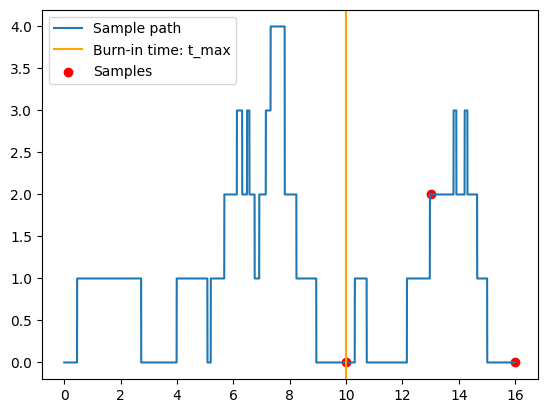

In [50]:
sample = sample_path_approximate(0, [1, 1], 3, 10, 3, plot=True)

Compare the stationary distribution estimates produce by the multiple path, independent sampling method to those produce by the new single path method:

In [51]:
def bootstrap_approx(x0, params, tmax, ts, n, N, plot=False, printing=False):
    """
    x0 = initial state
    params = [k1, k2]
    tmax = burn-in time for sampling
    ts = time between succesive samples
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = sample_path_approximate(x0, params, n, tmax, ts, plot=plot)
    x_max = max(states)
    x_list = [x for x in range(x_max + 1)]

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

In [76]:
x_max = 5
print(f"Multiple path estimates:")
s1 = time.time()
ests, ints = bootstrap([x for x in range(x_max + 1)], 0, [1,1], 100, 1000, 1000, printing=True)
print(f"Time = {time.time() - s1}")
print(f"\nSingle path estimates:")
s2 = time.time()
ests_app, ints_app = bootstrap_approx(0, [1, 1], 100, 10, 1000, 1000, printing=True)
print(f"Time = {time.time() - s2}")

Multiple path estimates:
95% CI for p(0) is: (0.345975, 0.403)
95% CI for p(1) is: (0.337, 0.398025)
95% CI for p(2) is: (0.159, 0.206)
95% CI for p(3) is: (0.046, 0.076)
95% CI for p(4) is: (0.005, 0.018)
95% CI for p(5) is: (0.001, 0.008)
Time = 0.5811281204223633

Single path estimates:
95% CI for p(0) is: (0.34, 0.4)
95% CI for p(1) is: (0.334, 0.394)
95% CI for p(2) is: (0.156, 0.203)
95% CI for p(3) is: (0.052, 0.083)
95% CI for p(4) is: (0.009, 0.024024999999999977)
95% CI for p(5) is: (0.0, 0.007)
Time = 0.2599003314971924


See that the single path approximate sampling is faster (somewhat obscured by the simple reaction and infefficient bootstrap) than the multiple path sampling, and gives estimates that seem to differ only by random chance (as expected with the bootstrap).

Used with the more efficient bootstrap implementation this could drastically speed up simulation of data.

## Test validity

To make sure the method is truly giving samples from the stationary distribution:
- compute estimates using single path sampling and multiple path sampling
- repeat, plotting difference between corresponding upper, and lower, bounds between methods
- repeat but instead comparing bounds both produced by the single path method

We expect that the difference in bounds (both for upper and lower bounds) should be symmetric about 0 (as they are interval estimates for the same values, so should be spread about the values) with small variation due to random sampling introduced by the bootstrap. The plots should not be significantly different when comparing the different methods vs comparing the same method:

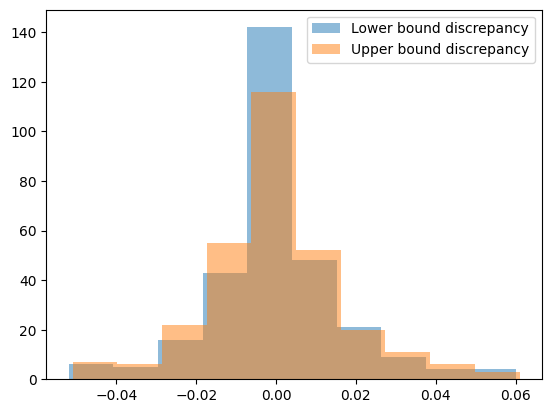

In [89]:
diff_l = []
diff_u = []
for k in range(50):
    x_max = 5
    ests, ints = bootstrap([x for x in range(x_max + 1)], 0, [1,1], 100, 1000, 1000)
    ests_app, ints_app = bootstrap_approx(0, [1, 1], 100, 10, 1000, 1000)
    for i in range(min(len(ints), len(ints_app))):
        old_interval = ints[i]
        new_interval = ints_app[i]
        diff_l.append(old_interval[0] - new_interval[0])
        diff_u.append(old_interval[1] - new_interval[1])
plt.hist(diff_l, alpha=0.5, label="Lower bound discrepancy")
plt.hist(diff_u, alpha=0.5, label = "Upper bound discrepancy")
plt.legend()
plt.show()

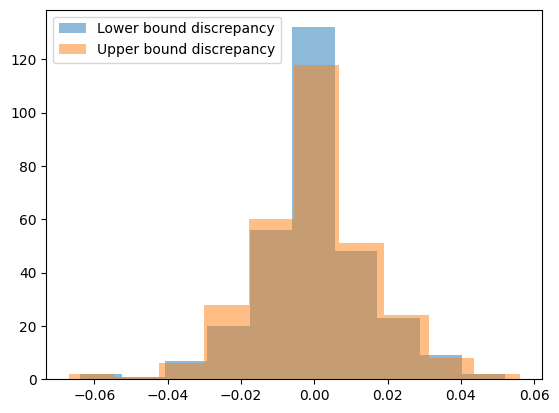

In [88]:
diff_l = []
diff_u = []
for k in range(50):
    x_max = 5
    ests, ints = bootstrap([x for x in range(x_max + 1)], 0, [1,1], 100, 1000, 1000)
    ests_app, ints_app = bootstrap([x for x in range(x_max + 1)], 0, [1,1], 100, 1000, 1000)
    for i in range(min(len(ints), len(ints_app))):
        old_interval = ints[i]
        new_interval = ints_app[i]
        diff_l.append(old_interval[0] - new_interval[0])
        diff_u.append(old_interval[1] - new_interval[1])
plt.hist(diff_l, alpha=0.5, label="Lower bound discrepancy")
plt.hist(diff_u, alpha=0.5, label = "Upper bound discrepancy")
plt.legend()
plt.show()

See that the plots follow expectations, so we can conclude that (in this case) both sampling methods produce samples from the stationary distribution of the chain and give the same interval estimates up to random variation.

However, need to be careful in practice that t_max is large enough for the chain to reach the stationary distribution (for both methods), and that t_s is large enough to prevent highly correlated samples, but small enough (<< t_max) that the method is worthwhile (t_s = t_max is effecitvely running the chain again from the last starting point).

# Non-linear Programming

So far have used the variables $ z_1 = k_1 p $ and $ z_2 = k_2 p $ to tranform the constraint Qp = 0 into a linear equality that can be used in an LP, which have many methods to quickly guarantee a global optimum. However, its possible that this extra 'layer' of variables can increase the width of the solution bounds, or the linearity restriction prevents useful bounds from being used (see gene expression reaction for more).

Using Gurobi we can solve non-convex problems to get a guarantee of global optima. Implementing is very simple and matches the mathematical description as we simply include $ k_1 $, $ k_2 $ and $p$ as variables in the model.

However, in the Gene Expression reaction we encountered problems of infeasibility when using too many bounds, despire the corresponding LP having no such problems. We implement and test the same method to see if these problems also occur for this, much simpler, model:

In [1]:
import gurobipy as gp
from gurobipy import GRB

In [2]:
def birth_death_NLP(indices, intervals, printing=False):
    """
    Arguments:
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    intervals: array of CI bounds on p (length at least N + 1)

    Returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu
            
    # create bounds on p
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Model
    m = gp.Model("gene_exp")

    # Variables: 
    # p in [0, 1], rates in [0, K] where max is set for computational reasons
    K = 100
    p = m.addMVar(shape=N + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
    k1= m.addVar(vtype=GRB.CONTINUOUS, name="k1", lb=0, ub=K)
    k2 = 1

    # Constraints
    # Stationary condition: Qp = 0
    m.addConstr(k1*(Q1 @ p) + k2*(Q2 @ p) == 0, name="Qp = 0")
    # CI bounds: p_L <= p <= p_U 0
    m.addConstr(pl <= p, name="CI lb")
    m.addConstr(p <= pu, name="CI ub" )
    # p is a truncated distribution: sum(p) <= 1
    m.addConstr(p.sum() <= 1, name="Dist")

    # Minimum objective
    m.setObjective(k1, GRB.MINIMIZE)

    try:
        # optimize (solve)
        m.optimize()
        # record
        min_val = m.ObjVal
    except:
        # record as infeasible/unbounded
        min_val = None

    # reset
    m.reset()

    # Maximum objective
    m.setObjective(k1, GRB.MAXIMIZE)

    try:
        # re-optimize (re-solve)
        m.optimize()
        # record
        max_val = m.ObjVal
    except:
        # record as infeasible/unbounded
        max_val = None

    if printing:
        print(f"k1 in ({min_val}, {max_val})")

    return min_val, max_val

In [29]:
def birth_death_LP(indices, intervals, printing=False):
    """
    Arguments:
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    intervals = array of CI bounds on p (at least N + 1)

    returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu
            
    # create bounds on p
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Construct the problem.
    k1 = cv.Variable(1)
    k2 = 1
    z1 = cv.Variable(N + 1)
    z2 = cv.Variable(N + 1)
    objective_max = cv.Maximize(k1)
    objective_min = cv.Minimize(k1)
    constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                z1 >= k1 * pl,
                z1 <= k1 * pu,
                z2 >= k2 * pl,
                z2 <= k2 * pu,
                sum([z1[x] for x in range(N + 1)]) <= k1,
                sum([z2[x] for x in range(N + 1)]) <= k2]
    prob_max = cv.Problem(objective_max, constraints)
    prob_min = cv.Problem(objective_min, constraints)   

    # Print result.
    prob_max.solve(solver=cv.GUROBI)
    prob_min.solve(solver=cv.GUROBI)
    if printing:
        print(f"k1 in ({prob_min.value}, {prob_max.value})")
    
    return prob_min.value, prob_max.value

## Testing

In [57]:
# create confidence intervals
k1 = 5
k2 = 1
x_max = 11
estimates, intervals = bootstrap([x for x in range(x_max)], 0, [k1, k2], 100, 1000, 1000, printing=True)

# true stationary distribution
true_p = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_max)]
for x in range(x_max):
    valid = False
    if intervals[x][0] <= true_p[x] and intervals[x][1] >= true_p[x]:
        valid = True
    print(f"True value of p({x}) is: {true_p[x]} , CI is {valid}")

95% CI for p(0) is: (0.001, 0.008)
95% CI for p(1) is: (0.022975000000000002, 0.044)
95% CI for p(2) is: (0.055, 0.086)
95% CI for p(3) is: (0.115, 0.158)
95% CI for p(4) is: (0.179, 0.227)
95% CI for p(5) is: (0.16, 0.20702499999999996)
95% CI for p(6) is: (0.11497500000000001, 0.15702499999999997)
95% CI for p(7) is: (0.087, 0.126)
95% CI for p(8) is: (0.045, 0.073)
95% CI for p(9) is: (0.024, 0.047)
95% CI for p(10) is: (0.012, 0.029)
True value of p(0) is: 0.006737946999085467 , CI is True
True value of p(1) is: 0.03368973499542734 , CI is True
True value of p(2) is: 0.08422433748856833 , CI is True
True value of p(3) is: 0.14037389581428056 , CI is True
True value of p(4) is: 0.1754673697678507 , CI is False
True value of p(5) is: 0.1754673697678507 , CI is True
True value of p(6) is: 0.1462228081398756 , CI is True
True value of p(7) is: 0.104444862957054 , CI is True
True value of p(8) is: 0.06527803934815875 , CI is True
True value of p(9) is: 0.03626557741564375 , CI is True
T

k1 in (2.871875, 44.0)
k1 in (2.871875, 7.486398258977148)
k1 in (4.011627906976745, 7.486398258977148)
k1 in (4.531645569620253, 7.486398258977148)
k1 in (4.531645569620253, 5.7828212290502785)
k1 in (4.531645569620253, 5.7828212290502785)
k1 in (4.531645569620253, 5.7828212290502785)
k1 in (4.531645569620253, 5.7828212290502785)
k1 in (4.531645569620253, 5.7828212290502785)


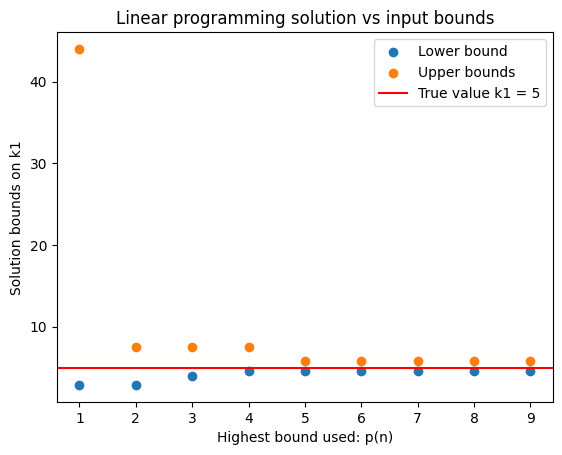

In [58]:
# solve using LP:
# range(N) => using equations [0, ..., N - 1] => bounds p(0), ..., p(N)
# solve using NLP
lbs, ubs = [], []
infeasible = []
ns = [n for n in range(1, x_max - 1)]
for n in ns:
    lb_LP, ub_LP = birth_death_LP(range(n), intervals, printing=True)
    lbs.append(lb_LP)
    ubs.append(ub_LP)
    if lb_LP == None:
        infeasible.append(n)
plt.scatter(ns, lbs, label="Lower bound")
plt.scatter(ns, ubs, label="Upper bounds")
for n in infeasible:
    plt.axvline(n, color="green")
plt.axhline(k1, label=f"True value k1 = {k1}", color="red")
plt.legend()
plt.xlabel("Highest bound used: p(n)")
plt.ylabel("Solution bounds on k1")
plt.title("Linear programming solution vs input bounds")
plt.show()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 3 columns and 6 nonzeros
Model fingerprint: 0x068e3dda
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e-03, 1e+00]
Presolve removed 5 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 5 rows and 0 columns
Presolve time: 0.00s
Presolved: 4 rows, 3 columns, 12 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 0 integer (0 binary)
Found heuristic solution: objective 2.8718750

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work

Continuous model is non-convex -- solving as a MIP

Presolve removed 7 rows and 0 columns
Presolve time: 0.00s
Presolved: 9 rows, 5 columns, 26 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 5 continuous, 0 integer (0 binary)
Found heuristic solution: objective 3.7080992

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 3.7081 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.708099246855e+00, best bound 3.708099240712e+00, gap 0.0000%
Discarded solution information
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 4 columns and 9 nonzeros
Model fingerprint:

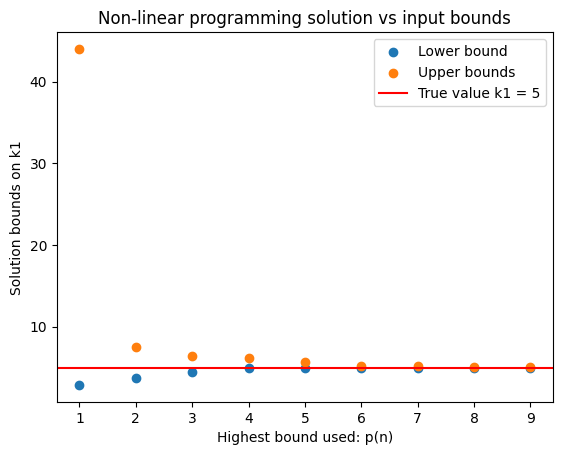

In [59]:
# solve using NLP
lbs, ubs = [], []
infeasible = []
ns = [n for n in range(1, x_max - 1)]
for n in ns:
    lb_NLP, ub_NLP = birth_death_NLP(range(n), intervals, printing=True)
    lbs.append(lb_NLP)
    ubs.append(ub_NLP)
    if lb_NLP == None:
        infeasible.append(n)
plt.scatter(ns, lbs, label="Lower bound")
plt.scatter(ns, ubs, label="Upper bounds")
for n in infeasible:
    plt.axvline(n, color="green")
plt.axhline(k1, label=f"True value k1 = {k1}", color="red")
plt.legend()
plt.xlabel("Highest bound used: p(n)")
plt.ylabel("Solution bounds on k1")
plt.title("Non-linear programming solution vs input bounds")
plt.show()

See that the solutions produced are very similar for both LP and NLP programs, but that the NLP bounds converge much closer to the true value than the LP bounds, which stagnate much earlier.

Importantly, the solutions of the NLP are very well behaved:
- infeability only seems to occur in situations where the LP is also infeasible, due to inaccurate bounds that cause conflicitng constraints
- the lower bounds only raises above the true value when several innaccurate bounds have been used, and few more will lead to infeasibility (this has potential to occur in the LP case too, but i suspect that the looser bounds mean this is less likely)

Also see that both the LP and NLP can often handle a few CI bounds that do not contain the true value, still giving accurate solution bounds as long as the bounds are not too wrong.